# Analysis of Spiking Experiment with BactoML

- [General settings](#General)
- [Calculation with MCCD - PB](#PB)
- [Calculation with MCCD - PhenoFlow](#Pheno)

The data can be downloaded from FlowRepository.org under the repository ID `FR-FCM-Z2D`.

In this notebook, the data is supposed to be located in the folder `./Wastewater_FlowRepos/`

In [1]:
import time
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd

from bactoml.df_pipeline import DFLambdaFunction, DFFeatureUnion, DFInPlaceLambda, AggregatedHist
from bactoml.decision_tree_classifier import HistogramTransform, DTClassifier
from bactoml.fcdataset import FCDataSet
from bactoml.kNN_model import NNDistanceModel
from bactoml.pheno_indexes import PhenoIndexes

import FlowCytometryTools as fct
from FlowCytometryTools import PolyGate, ThresholdGate

from sklearn.pipeline import Pipeline

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## General settings  <a id = 'General'></a>

In [2]:
#t-log transform
tlog_step = ('tlog_step', DFLambdaFunction(lambda x : x.transform('tlog', 
                                                             channels=['FL1', 'FL2', 'SSC'], 
                                                             th=1, r=1, d=1, 
                                                             auto_range=False)))
   
#ICC gate

p_FL1 = 4

icc_gate_step = ('icc_gate_step', DFLambdaFunction(lambda x : x.gate(PolyGate([[p_FL1, 0.05], [p_FL1, 3.2], [6.5, 5.7], [6.5, 0.05]],
                                                                              ['FL1', 'FL2']))))

tcc_gate_step = ('tcc_gate_step', DFLambdaFunction(lambda x : x.gate(PolyGate([[p_FL1, 0.05], [p_FL1, 3.2], [6.5, 5.7], [6.5, 0.05]],
                                                                              ['FL1', 'FL2']))))

# Dead Cell Count gate
dcc_gate_step = ('dcc_gate_step', DFLambdaFunction(lambda x : x.gate(PolyGate([[3.2, 4], [3.2, 5.2], [6.5, 6.7], [6.5, 5.7], [4.2, 3.2]],
                                                                              ['FL1', 'FL2']))))

#HNA gate
hna_gate_step = ('hna_gate_step', DFLambdaFunction(lambda x : x.gate(ThresholdGate(4.8, 'FL1', 'above'))))

#event counter
event_counter_step = ('event_count_step', DFLambdaFunction(lambda x : x.shape[0]))

#extract volume from metadata
meta_volume_step = ('meta_volume_step', DFLambdaFunction(lambda x : float(x.get_meta()['$VOL']) * 1E-6))

#extract time from metadata
meta_time_step = ('meta_time_step', DFLambdaFunction (lambda x : datetime.datetime.strptime("{$DATE} {$BTIM}".format(**x.get_meta()), "%d-%b-%Y %H:%M:%S")))

#assemble the linear steps of pipeline using sklearn Pipeline
pre_pipe = Pipeline([tlog_step, tcc_gate_step]) # preprocessing pipe

# edges for the finely spaced histogram used to calculate the aggregated super histogram
edges_bin = {'FL1':np.linspace(p_FL1, 6.5, 200),
         'SSC':np.linspace(0.05, 6.6, 200)}

histogram_transform_step = ('histogram_transform_step', HistogramTransform(edges=edges_bin))

# parameters for the binning algorithm
k = 5
decision_tree_step = ('decision_tree_step', DTClassifier(max_depth=k, columns=['FL1', 'SSC'], normalized = True))

#assemble the linear steps of pipeline using sklearn Pipeline
fp_pipe = Pipeline([histogram_transform_step, decision_tree_step]) # fingerprinting pipe

#branch the pipeline using DFFeatureUnion
feature_union_all = DFFeatureUnion([('TCC_abs', Pipeline([event_counter_step])), #note that DFFeatureUnion parallel branches must be Pipeline instances
                                  ('VOL', Pipeline([meta_volume_step])),
                                   ('TIME', Pipeline([meta_time_step])),
                                  ('HNAC', Pipeline([tcc_gate_step, hna_gate_step, event_counter_step])),
                                  ('BIN_SIZE', fp_pipe)])

feature_union_pb = DFFeatureUnion([('BIN_SIZE', fp_pipe)])

In [3]:
def load_pipeline(PATH, pipeline):
    
    """
    Apply the pipeline to a folder with FCS measurements.
    Sort by date and return a pandas dataframe with TIME index
    and features of the FeatureUnion of the applied pipeline.
    """
    
    # load dataset
    fc_dataset = FCDataSet(PATH)
    df = pipeline.fit_transform(fc_dataset)
    
    df.set_index('TIME', inplace = True)
    return df

def feature_norm_ldc(df):
    
    """
    Process the features to obtain the standard metrics.
    """
    
    df['HNAP'] = df['HNAC']/df['ICC_abs']
    df['TCC'] = (df['ICC_abs']+df['DCC_abs'])/df['VOL']
    df['ICC'] = df['ICC_abs']/df['VOL']
    df['DCC'] = df['DCC_abs']/df['VOL']
    return df

def feature_norm(df):
    
    """
    Process the features to obtain the standard metrics.
    """
    
    df['HNAP'] = df['HNAC']/df['TCC_abs']
    df['TCC'] = (df['TCC_abs'])/df['VOL']
    return df

In [4]:
PATH_DATA = 'Wastewater_FlowRepos/'
PATH_Figure = 'Figures/'

## Calculation with MCCD - PB <a id = 'PB'></a>



In [5]:
### Calculate the fingerprints & classical metrics

# generate an aggregated histogram
fcms_ref = FCDataSet(PATH_DATA, pattern = '*ref*')
super_hist = AggregatedHist(fcms_ref, edges_bin).aggregate()

# perform the fit of the PB algorithm on the aggregated super histogram
fp_pipe.named_steps.decision_tree_step.fit(super_hist);

# apply the pipeline to every measurement in the test dataset
fcms_online = FCDataSet(PATH_DATA)
output_online = pd.concat((feature_union_all.transform(fc) for fc in fcms_online), axis=0)
output_online.set_index('TIME', inplace = True)

# calculate normalized classic metrics
output_online = feature_norm(output_online)

# calculate the reference fingerprints
output_ref = pd.concat((feature_union_pb.transform(fc) for fc in fcms_ref), axis=0)

### Calculate the outlier score

# fit the kNN model
outlier_detection = NNDistanceModel(['BIN_SIZE_{}'.format(str(i)) for i in range(2**k)], n_neighbors = 5).fit(output_ref)
# calculate the outlier score
outlier_score = outlier_detection.transform(output_online)
# concatenate the result to output_online
output_online['outlier_score'] = outlier_score['outlier_score']

In [6]:
output_online.head(2)

,TCC_abs,VOL,HNAC,BIN_SIZE_0,BIN_SIZE_1,BIN_SIZE_2,BIN_SIZE_3,BIN_SIZE_4,BIN_SIZE_5,BIN_SIZE_6,...,BIN_SIZE_25,BIN_SIZE_26,BIN_SIZE_27,BIN_SIZE_28,BIN_SIZE_29,BIN_SIZE_30,BIN_SIZE_31,HNAP,TCC,outlier_score
TIME,,,,,,,,,,,,,,,,,,,,,
2019-10-24 14:38:35,51081,0.08991,21314,0.068915,0.062269,0.039502,0.063851,0.032301,0.037365,0.049115,...,0.027099,0.020315,0.016892,0.026288,0.018554,0.022055,0.019266,0.417259,568134.801468,0.013622
2019-10-24 15:08:35,51648,0.09000,21331,0.071073,0.062451,0.037467,0.062529,0.032587,0.036173,0.049636,...,0.029726,0.020830,0.017420,0.027571,0.017852,0.023730,0.022417,0.413007,573866.666667,0.013560


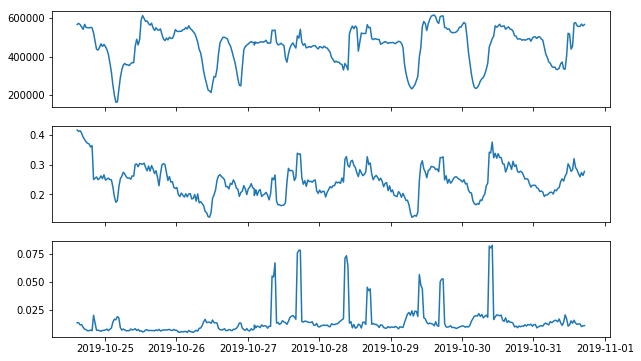

In [7]:
# basic plot
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize= [10,6], sharex = True)
ax[0].plot(output_online.index, output_online.TCC)
ax[1].plot(output_online.index, output_online.HNAP)
ax[2].plot(output_online.index, output_online.outlier_score)

### Figure 5 from Paper

In [8]:
times_waste = {'spike1': [datetime.datetime(2019, 10, 27, 7, 55), datetime.datetime(2019, 10, 27, 9, 25), 1.96],
                 'spike2': [datetime.datetime(2019, 10, 27, 16, 25), datetime.datetime(2019, 10, 27, 17, 55), 1.96],
                 'spike3': [datetime.datetime(2019, 10, 28, 8, 25), datetime.datetime(2019, 10, 28, 9, 55), 1.96],
                 'spike4': [datetime.datetime(2019, 10, 28, 15, 55), datetime.datetime(2019, 10, 28, 17, 25), 1.45],
                   'spike5': [datetime.datetime(2019, 10, 29, 9, 25), datetime.datetime(2019, 10, 29, 10, 55), 1.79],
                'spike6': [datetime.datetime(2019, 10, 29, 16, 25), datetime.datetime(2019, 10, 29, 17, 55), 1.98],
               'spike7': [datetime.datetime(2019, 10, 30, 8, 55), datetime.datetime(2019, 10, 30, 10, 25), 2.64],
                  'ref': [datetime.datetime(2019, 10, 24, 14, 38), datetime.datetime(2019, 10, 27, 1, 38,35)],
                 'blank1': [datetime.datetime(2019, 10, 30, 15, 25), datetime.datetime(2019, 10, 30, 16, 55)]}

# define a color dictionary
c_dic = {'ICC': "#373a3f", 'TCC': "#6ba388", 'DCC': "#a36873", 'HNAP': "#d39032", 'EB_Debit': "#086577", 
        'EB_Temp': "#566ec9", 'chlore': "#025b13", 'EB_Turb': "#593903", 'ET_Turb': "#ceb994",
        'Radiation': "#edd663", 'T_Air': "#b55522", 'Precipitation': '#0435c9', 'Wind': '#149133',
        'fp': '#1db7a3', 'PB': '#092f7a','GMM': '#820722', 'Pheno': '#1a7548',
        'raw_water': '#0e48a5', 'sand': '#ada068', 'chlor': '#128237',
        'ref': '#b1d8b6', 'blank': '#7591bf', 'ref_text': '#067d38',
        'spike_text': '#b3474f'}

In [9]:
micro_df = output_online
FP_df = output_online

In [10]:
def plot_pi_profile(fig, ax, micro_df, FP_df, times, num_spike):
    
    l = 10 # tickparams size
    
    # plot TCC, HNAP & Outlier score

    ax[0].plot(micro_df.index, micro_df.TCC/1000, color = 'k')

    ax[1].plot(micro_df.index, micro_df['HNAP']*100, color='k')

    ax[2].plot(FP_df.index, FP_df.outlier_score, color = 'k')
    
    # plot the spiking profile
    
    profile_y = [0]
    profile_x = [times['ref'][0]]
    for s in range(1, num_spike+1):
        profile_y.extend([0, times['spike'+str(s)][2]])
        profile_x.extend([times['spike'+str(s)][0], times['spike'+str(s)][1]])

    profile_x.append(micro_df.index[-1])
    profile_y.append(0)
    ax[3].step(profile_x, profile_y, color = 'k')
    

    ## formatting
    for j in range(4):
        ax[j].xaxis.grid(True)  
        ax[j].tick_params(labelsize = l)   
        # spiking periods
        for s in range(1, num_spike+1):
            ax[j].axvspan(times['spike' + str(s)][0], times['spike' + str(s)][1], alpha=0.7, color='#f9bab6')

    # labels and description

    for j in range(2,3):
        # reference period
        ax[j].axvspan(times['ref'][0], times['ref'][1], alpha=1, color= c_dic['ref'])

    # datelabels
    ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
    #ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
    
    xlabels = []
    for i in range(1,8):
        xlabels.append('Day '+str(i))
    ax[0].set_xticklabels(xlabels)
    
    fig.autofmt_xdate()
    
    fig.align_ylabels(ax)
    
    return fig, ax


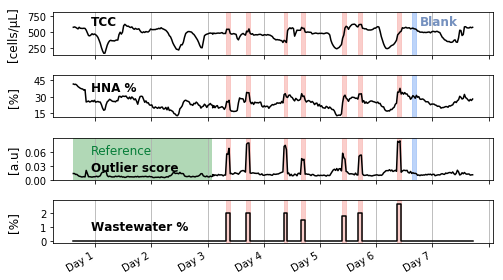

In [11]:
times = times_waste
num_spike =  7

fig, ax = plt.subplots(4, 1, figsize = (7.09, 4), sharex = True)
fig, ax = plot_pi_profile(fig, ax, micro_df, FP_df, times, num_spike)

# fontsize of text
fb = 20   
ft = 12



# add blanks to the figure
  
for j in range(3):
    for s in range(1,2):
        ax[j].axvspan(times['blank' + str(s)][0], times['blank' + str(s)][1], alpha=0.7, color='#a1c2f7')


ax[0].text(times['blank1'][0] + timedelta(hours = 3), 600, 'Blank', color = c_dic['blank'], fontsize = ft, weight = 'bold')

f = 12
ax[0].set_ylabel('[cells/'u'\u03bc''L]', fontsize = f)
ax[1].set_ylabel('[%]', fontsize = f)
ax[2].set_ylabel('[a.u]', fontsize = f)
ax[3].set_ylabel('[%]', fontsize = f)
fig.align_ylabels(ax)

# line labels

x = datetime.datetime(2019, 10, 24, 22)
ax[0].text(x, 600, 'TCC', color = 'k', fontsize = f, weight = 'bold')
ax[1].text(x, 35, 'HNA %', color = 'k', fontsize = f, weight = 'bold')
ax[2].text(x, 0.02, 'Outlier score', color = 'k', fontsize = f, weight = 'bold')
ax[3].text(x, .8, 'Wastewater %', color = 'k', fontsize = f, weight = 'bold')


ax[2].text(x, 0.055, 'Reference', color = c_dic['ref_text'], fontsize = ft)

ax[0].set_ylim(top = 800)

ax[1].set_ylim(top = 50)
ax[1].yaxis.set_ticks(np.arange(15, 50, 15))

ax[2].set_ylim(top = 0.09)
ax[2].yaxis.set_ticks(np.arange(0, 0.09, 0.03))

ax[3].set_ylim(top = 2.9)
ax[3].yaxis.set_ticks(np.arange(0, 2.5, 1))


fig.tight_layout()

#fig.savefig(PATH_Figure + '/Fig5.eps', format = 'eps')
#fig.savefig(PATH_Figure + '/Fig5.png', dpi = 300)

## Calculation with MCCD - PhenoFlow <a id = 'Pheno'></a>

In [12]:
# parameters for the Pheno algorithm

channels = ['FL1', 'SSC']
dist = 'euclidean' # 'euclidean', 'cosine', 'cityblock' or any scikit-learn distances

n = 128

edges_pheno = {'FL1':np.linspace(4.2, 6.5, n),
             'SSC':np.linspace(0.05, 6.6, n)}

down_phen = True
downsample_perc = 0.1

pheno_step = ('pheno_step', PhenoIndexes(edges_pheno,
                                         downsampling = down_phen, downsample_perc = downsample_perc))

#assemble the linear steps of pipeline using sklearn Pipeline
pheno_pipe = Pipeline([pheno_step]) # fingerprinting pipe

#branch the pipeline using DFFeatureUnion
feature_union_pheno = DFFeatureUnion([('PHENO_INDEX', pheno_pipe)])

In [13]:
np.random.seed(seed=42)

### Calculate the pheno fingerprints 

# calculate the reference fingerprints
output_ref = pd.concat((feature_union_pheno.transform(fc) for fc in fcms_ref), axis=0)

# calculate the online fingerprints
output_online_pheno = pd.concat((feature_union_pheno.transform(fc) for fc in fcms_online), axis=0)

### Calculate the outlier score

# fit the kNN model
outlier_detection = NNDistanceModel(['PHENO_INDEX_{}'.format(str(i)) for i in range(3)]).fit(output_ref)
# calculate the outlier score
outlier_score_pheno = outlier_detection.transform(output_online_pheno)

outlier_score_pheno.index = output_online.index

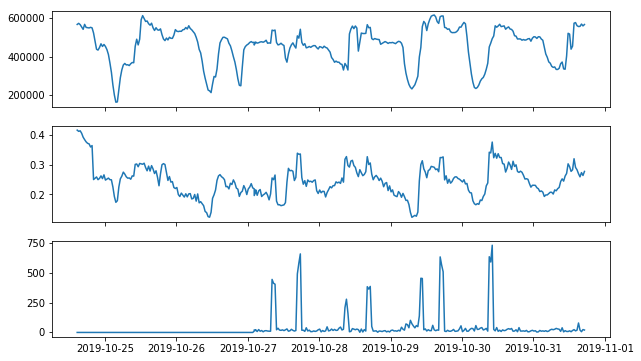

In [14]:
# basic plot
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize= [10,6], sharex = True)
ax[0].plot(output_online.index, output_online.TCC)
ax[1].plot(output_online.index, output_online.HNAP)
ax[2].plot(output_online.index, outlier_score_pheno.outlier_score)

## Figure 6 from paper

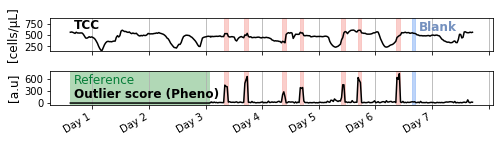

In [15]:
times = times_waste
num_spike =  7
l = 10

fig, ax = plt.subplots(2, 1, figsize = (7.09, 2), sharex = True)

ax[0].plot(output_online.index, output_online.TCC/1000, color = 'k')
ax[1].plot(output_online.index, outlier_score_pheno.outlier_score, color = 'k')

for j in range(2):
        ax[j].xaxis.grid(True)  
        ax[j].tick_params(labelsize = l)   
        # spiking periods
        for s in range(1, num_spike+1):
            ax[j].axvspan(times['spike' + str(s)][0], times['spike' + str(s)][1], alpha=0.7, color='#f9bab6')

# labels and description

for j in range(1,2):
    # reference period
    ax[j].axvspan(times['ref'][0], times['ref'][1], alpha=1, color= c_dic['ref'])


ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
#ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))

xlabels = []
for i in range(1,8):
    xlabels.append('Day '+str(i))
ax[0].set_xticklabels(xlabels)

fig.autofmt_xdate()

fig.align_ylabels(ax)

for j in range(2):
    for s in range(1,2):
        ax[j].axvspan(times['blank' + str(s)][0], times['blank' + str(s)][1], alpha=0.7, color='#a1c2f7')


ax[0].text(times['blank1'][0] + timedelta(hours = 3), 600, 'Blank', color = c_dic['blank'], fontsize = ft, weight = 'bold')

f = 12
ax[0].set_ylabel('[cells/'u'\u03bc''L]', fontsize = f)
ax[1].set_ylabel('[a.u]', fontsize = f)
fig.align_ylabels(ax)

# line labels

x = datetime.datetime(2019, 10, 24, 16)
ax[0].text(x, 650, 'TCC', color = 'k', fontsize = f, weight = 'bold')
ax[1].text(x, 120, 'Outlier score (Pheno)', color = 'k', fontsize = f, weight = 'bold')

ax[1].text(x, 470, 'Reference', color = c_dic['ref_text'], fontsize = ft)

ax[0].set_ylim(top = 900)
ax[1].set_ylim(top = 800)
ax[1].yaxis.set_ticks(np.arange(0, 700, 300))

fig.tight_layout()

#fig.savefig(PATH_Figure + '/Fig6.eps', format = 'eps')
#fig.savefig(PATH_Figure + '/Fig6.png', dpi = 300)